In [ ]:
pip install numpy pandas matplotlib seaborn scikit-learn opencv-python tensorflow torch torchvision albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

# Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r "/content/drive/MyDrive/dataset" /content/

Mounted at /content/drive


In [4]:
import os
import shutil
import random
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

# === STEP 1: Clean Split Directory & Re-Split Dataset ===

original_dataset_path = "/content/dataset"
base_split_path = "/content/dataset_split"
train_dir = os.path.join(base_split_path, "train")
test_dir = os.path.join(base_split_path, "test")

# Clean previous splits if any
if os.path.exists(base_split_path):
    shutil.rmtree(base_split_path)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

class_names = os.listdir(original_dataset_path)
split_ratio = 0.8

for class_name in class_names:
    class_path = os.path.join(original_dataset_path, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

print("✅ Dataset split completed!")

# === STEP 2: Data Preparation ===

IMG_SIZE = (224, 224)
BATCH_SIZE = 8

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,  # 15% of train used as validation
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.25,
    horizontal_flip=True,
    shear_range=0.2,
    brightness_range=[0.7, 1.3]
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True,
    seed=42
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Optional: Check class distribution
print("\n✅ Class distribution in training data:")
print(train_data.class_indices)
print("Samples per class:", train_data.classes.sum(), np.bincount(train_data.classes))

# === STEP 3: Define the Model with MobileNetV2 ===

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  ## MAX pooling
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === STEP 4: Callbacks ===

early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

# === STEP 5: Initial Training ===

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

# === STEP 6: Fine-tuning ===

# Unfreeze the base model
base_model.trainable = True
# Recompile with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n🔁 Starting fine-tuning...")
history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[early_stopping, checkpoint, lr_scheduler]
)

# === STEP 7: Evaluate on Test Set ===

test_loss, test_acc = model.evaluate(test_data)
print(f"\n✅ Final Test Accuracy: {test_acc:.4f}")

# === STEP 8: Confusion Matrix and Classification Report ===

y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_labels = (y_pred > 0.5).astype("int32").flatten()

print("\n🧾 Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_labels))
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=test_data.class_indices.keys()))


✅ Dataset split completed!
Found 136 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 40 images belonging to 2 classes.

✅ Class distribution in training data:
{'First Print': 0, 'Second Print': 1}
Samples per class: 68 [68 68]
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 881ms/step - accuracy: 0.4769 - loss: 1.1946 - val_accuracy: 0.5417 - val_loss: 0.9044 - learning_rate: 1.0000e-04
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 734ms/step - accuracy: 0.5847 - loss: 0.9432 - val_accuracy: 0.6667 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 724ms/step - accuracy: 0.6565 - loss: 0.8358 - val_accuracy: 0.8333 - val_loss: 0.7163 - learning_rate: 1.0000e-04
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 712ms/step - accuracy: 0.6883 - loss: 0.7656 - val_accuracy: 0.9583 - val_loss: 0.6037 - learning_rate: 1.0000e-04
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 702ms/step - accuracy: 0.8713 - loss: 0.6027 - val_accuracy: 0.8750 - val_loss: 0.5844 - learning_rate: 1.0000e-04
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - accuracy: 0.8307 - loss: 0.6174 - val_accuracy: 0.9583 - val_loss: 0.5449 - learning_rate: 1.0000e-04
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 703ms/step - acc

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


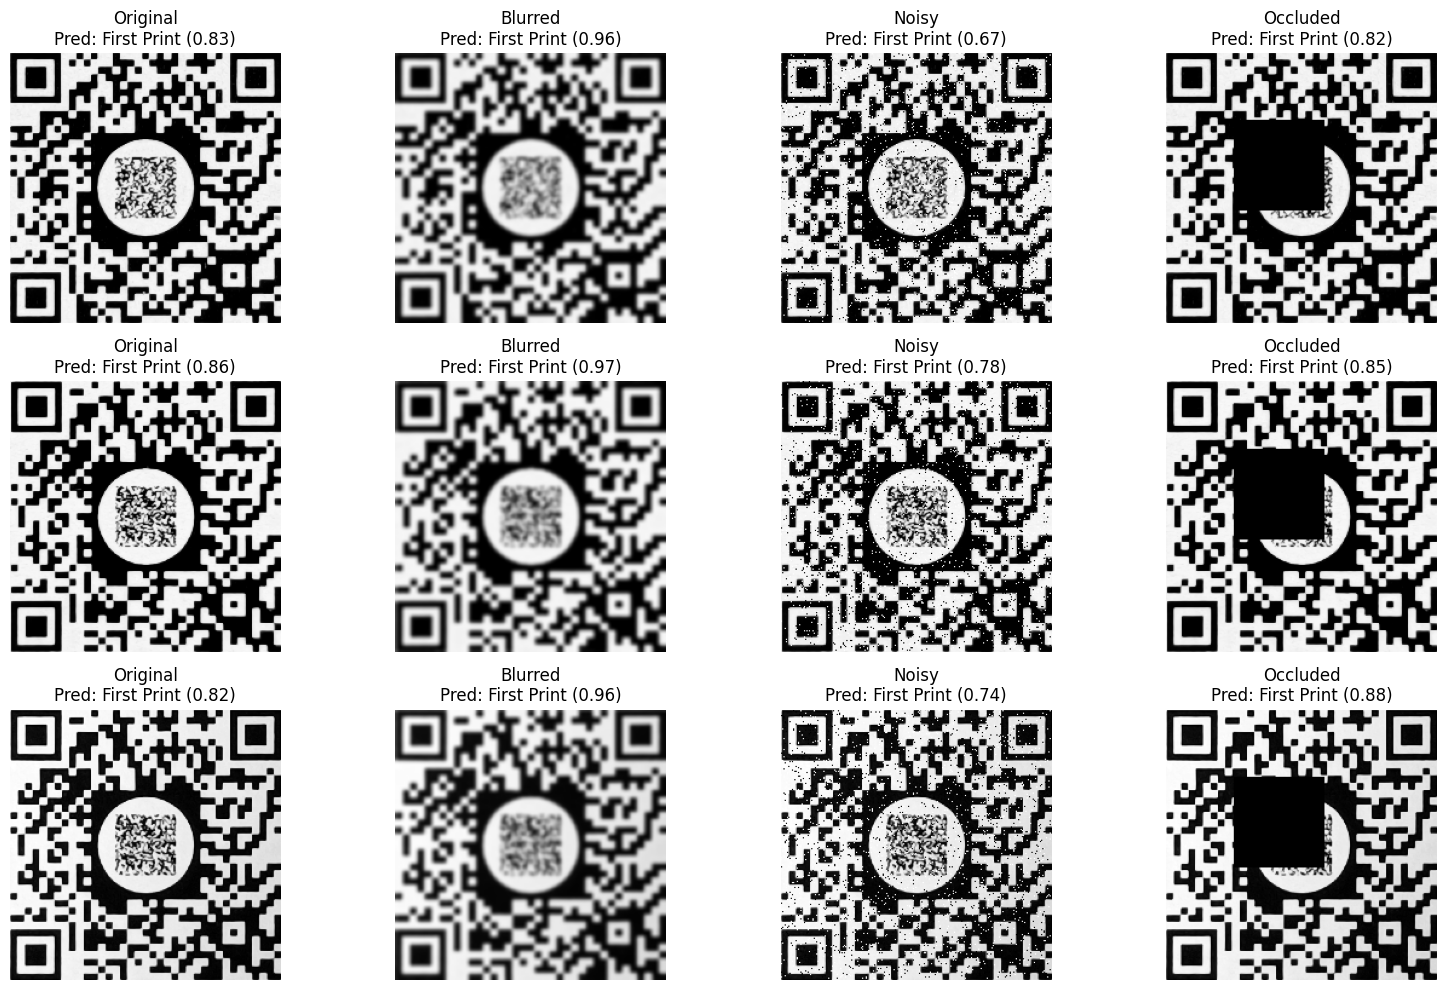

In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Helper: Load and preprocess an image
def preprocess_image(img_path, target_size=(224, 224)):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    return img_array

# Distortion Functions
def add_blur(image, ksize=7):
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

def add_salt_pepper_noise(image, amount=0.02):
    noisy = np.copy(image)
    num_salt = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    noisy[coords[0], coords[1], :] = 255

    num_pepper = np.ceil(amount * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    noisy[coords[0], coords[1], :] = 0
    return noisy

def add_occlusion(image):
    occluded = image.copy()
    h, w = image.shape[:2]
    start_x, start_y = w//4, h//4
    end_x, end_y = start_x + w//3, start_y + h//3
    cv2.rectangle(occluded, (start_x, start_y), (end_x, end_y), (0, 0, 0), -1)
    return occluded

# Load a few test image paths (you can adjust this)
test_image_paths = test_data.filepaths[:3]  # First 3 test images

# Plot and predict
fig, axes = plt.subplots(len(test_image_paths), 4, figsize=(16, 10))
distortions = [("Original", lambda x: x),
               ("Blurred", add_blur),
               ("Noisy", add_salt_pepper_noise),
               ("Occluded", add_occlusion)]

for i, path in enumerate(test_image_paths):
    original_img = preprocess_image(path)

    for j, (label, distort_fn) in enumerate(distortions):
        distorted_img = distort_fn(original_img.astype(np.uint8))
        input_img = preprocess_input(distorted_img.astype(np.float32))
        input_img = np.expand_dims(input_img, axis=0)

        pred_prob = model.predict(input_img)[0][0]
        pred_label = "Second Print" if pred_prob > 0.5 else "First Print"
        confidence = f"{pred_prob:.2f}" if pred_prob > 0.5 else f"{1 - pred_prob:.2f}"

        axes[i, j].imshow(distorted_img.astype("uint8"))
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{label}\nPred: {pred_label} ({confidence})")

plt.tight_layout()
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step
📊 Classification Report:

              precision    recall  f1-score   support

 First Print       1.00      1.00      1.00        20
Second Print       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



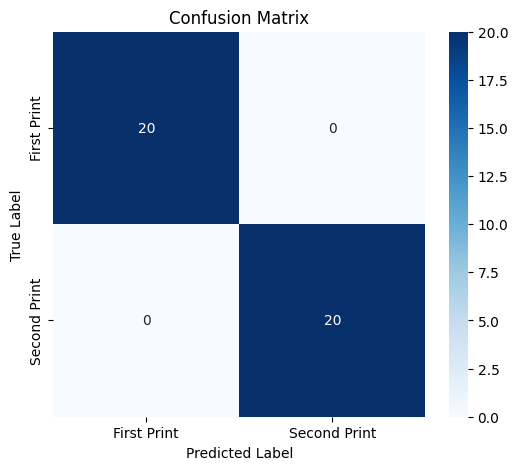

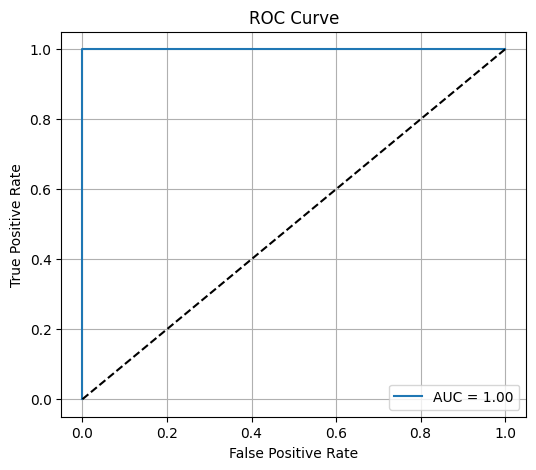

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import itertools

# === Get True Labels and Predictions ===

# Get the ground truth labels
true_labels = test_data.classes

# Predict probabilities
pred_probs = model.predict(test_data)
pred_labels = (pred_probs > 0.5).astype("int32").flatten()

# === Classification Report ===

print("📊 Classification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=test_data.class_indices.keys()))

# === Confusion Matrix ===

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# === ROC Curve ===

fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


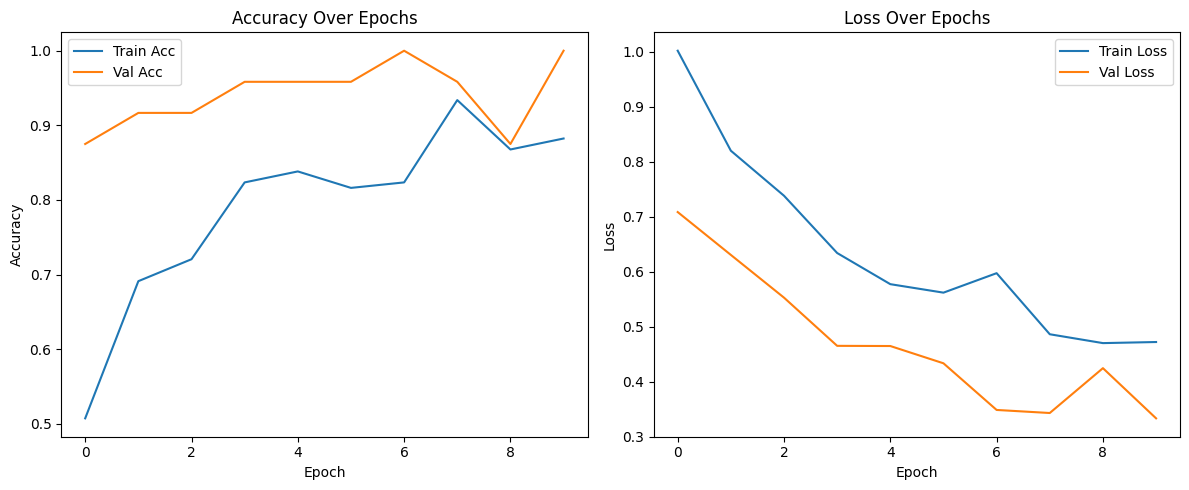

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
